In [37]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

### Cleaning of General Data

In [38]:
# Import electricity generation data
elec_gen = pd.read_csv('raw/electric_gen.csv')
emissions = pd.read_csv('raw/co2_emissions_from_energy_consumption.csv')
elec_cost = pd.read_csv('raw/electric_cost.csv')

# Only keep desired rows
elec_gen = elec_gen[elec_gen.Column_Order == 9]
emissions = emissions[emissions.Column_Order == 14]
elec_cost = elec_cost[elec_cost.Column_Order == 6]

# Only keep rows with valid dates
elec_gen["YYYYMM"] = elec_gen.apply(lambda row : str(row["YYYYMM"]), axis=1)
elec_gen = elec_gen[elec_gen["YYYYMM"].str.contains("[1-2][0-9][0-9][0-9](1[0-2]|0[1-9])")]

emissions["YYYYMM"] = emissions.apply(lambda row : str(row["YYYYMM"]), axis=1)
emissions = emissions[emissions["YYYYMM"].str.contains("[1-2][0-9][0-9][0-9](1[0-2]|0[1-9])")]

elec_cost["YYYYMM"] = elec_cost.apply(lambda row : str(row["YYYYMM"]), axis=1)
elec_cost = elec_cost[elec_cost["YYYYMM"].str.contains("[1-2][0-9][0-9][0-9](1[0-2]|0[1-9])")]

# Convert string to date
elec_gen["Date"] = elec_gen.apply(lambda row : datetime.strptime(str(row["YYYYMM"]).strip(), "%Y%m"), axis=1)
# elec_gen.set_index("Date", inplace=True)

emissions["Date"] = emissions.apply(lambda row : datetime.strptime(str(row["YYYYMM"]).strip(), "%Y%m"), axis=1)
# emissions.set_index("Date", inplace=True)

elec_cost["Date"] = elec_cost.apply(lambda row : datetime.strptime(str(row["YYYYMM"]).strip(), "%Y%m"), axis=1)
# elec_cost.set_index("Date", inplace=True)

# Drop unneeded columns
elec_gen.drop(["YYYYMM", "MSN", "Column_Order", "Description", "Unit"], axis=1, inplace=True)
emissions.drop(["YYYYMM", "MSN", "Column_Order", "Description", "Unit"], axis=1, inplace=True)
elec_cost.drop(["YYYYMM", "MSN", "Column_Order", "Description", "Unit"], axis=1, inplace=True)

# Drop NaN values
elec_cost = elec_cost[pd.to_numeric(elec_cost["Value"], errors="coerce").notnull()]

# Drop values from before 2000 (no cryptocurrencies invented until 2008)
year_2005 = datetime(2000, 1, 1)
elec_gen = elec_gen[elec_gen["Date"] > year_2005]
emissions = emissions[emissions["Date"] > year_2005]
elec_cost = elec_cost[elec_cost["Date"] > year_2005]

# Convert values to KWh, Metric Tons of CO2, and Dollars per KWh, respectively
elec_gen["Gen [KWh]"] = elec_gen.apply(lambda row : (float(row["Value"]) * 1000000000), axis=1)
emissions["Emissions [Metric Tons CO2]"] = emissions.apply(lambda row : (float(row["Value"]) * 1000000), axis=1)
elec_cost["Cost [USD per KWh]"] = elec_cost.apply(lambda row : (float(row["Value"]) / 100), axis=1)

elec_gen.reset_index(inplace=True)
emissions.reset_index(inplace=True)
elec_cost.reset_index(inplace=True)

/tmp/ipykernel_67024/718399321.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  elec_gen = elec_gen[elec_gen["YYYYMM"].str.contains("[1-2][0-9][0-9][0-9](1[0-2]|0[1-9])")]
/tmp/ipykernel_67024/718399321.py:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  emissions = emissions[emissions["YYYYMM"].str.contains("[1-2][0-9][0-9][0-9](1[0-2]|0[1-9])")]
/tmp/ipykernel_67024/718399321.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  elec_cost = elec_cost[elec_cost["YYYYMM"].str.contains("[1-2][0-9][0-9][0-9](1[0-2]|0[1-9])")]


In [39]:
# Calculate emissions per KWh of energy produced
elec_emissions = pd.DataFrame()
elec_emissions["Energy Emissions (Metric Tons CO2 / KWh)"] = emissions["Emissions [Metric Tons CO2]"] / elec_gen["Gen [KWh]"]
elec_emissions["Date"] = emissions["Date"]

### Visualizations of General Data

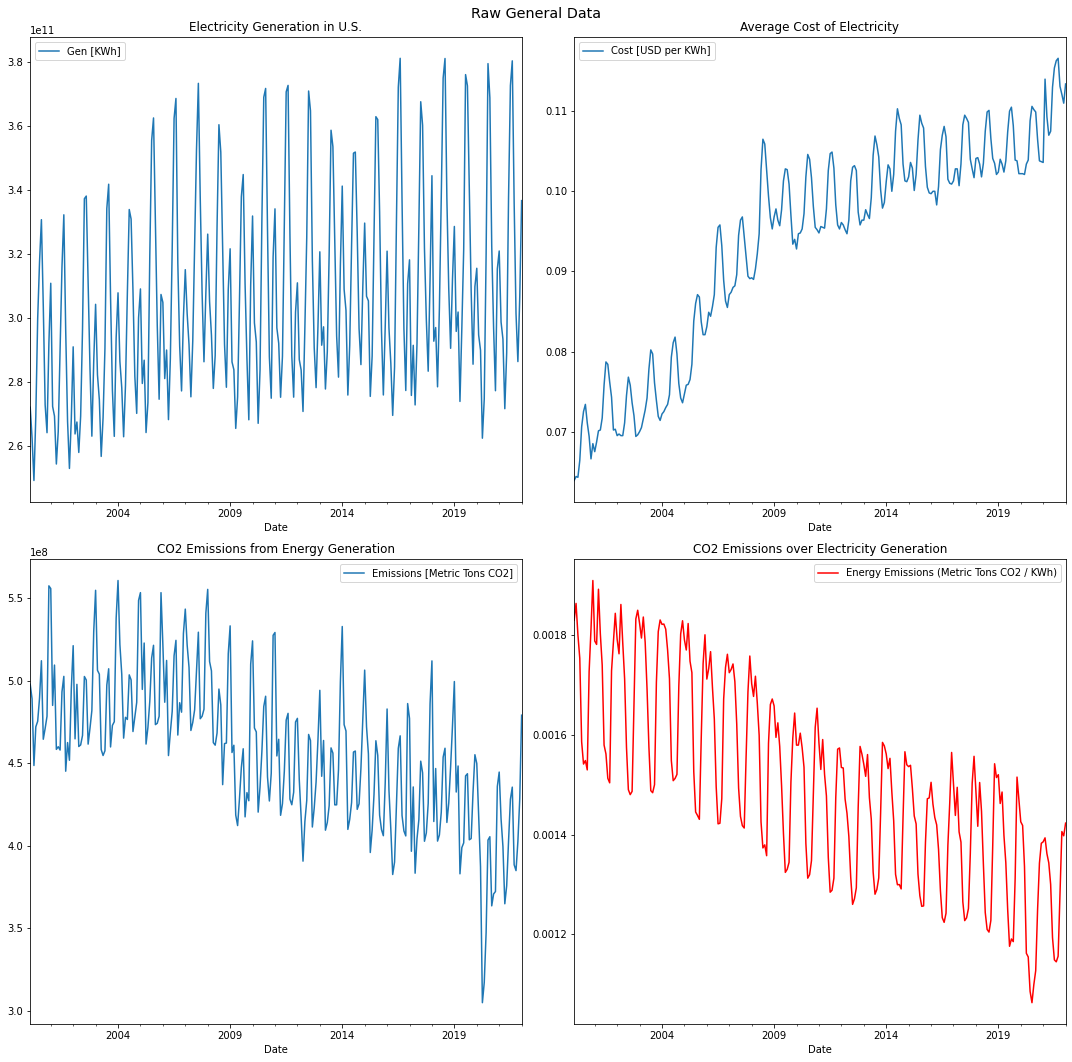

In [40]:
# Visualizations of raw general data
fig, axes = plt.subplots(2, 2, figsize=(15,15))
plt.suptitle("Raw General Data", size='x-large')
elec_gen.plot(ax=axes[0, 0], x="Date", y="Gen [KWh]", kind="line", title="Electricity Generation in U.S.")
emissions.plot(ax=axes[1, 0],x="Date", y="Emissions [Metric Tons CO2]", kind="line", title="CO2 Emissions from Energy Generation")
elec_cost.plot(ax=axes[0, 1],x="Date", y="Cost [USD per KWh]", kind="line", title="Average Cost of Electricity")
elec_emissions.plot(ax=axes[1, 1], x="Date", y="Energy Emissions (Metric Tons CO2 / KWh)", kind="line", title="CO2 Emissions over Electricity Generation", color="red")
fig.tight_layout()
plt.show()

### Cleaning of Coins Pricing Data

In [41]:
# Import data for each coin
nano = pd.read_csv("raw/xno_pricing.csv")
cardano = pd.read_csv("raw/ada_pricing.csv")
algorand = pd.read_csv("raw/algo_pricing.csv")
solana = pd.read_csv("raw/sol_pricing.csv")
hedera = pd.read_csv("raw/hbar_pricing.csv")

# Set names
nano.name="Nano"
cardano.name="Cardano"
algorand.name="Algorand"
solana.name="Solana"
hedera.name="Hedera"

coins_dfs = [nano, cardano, algorand, solana, hedera]
# Clean each dataframe
for index, df in enumerate(coins_dfs):
    # Convert string to date
    df["Date"] = df.apply(lambda row: datetime.strptime(
        str(row["snapped_at"]).strip(), "%Y-%m-%d %H:%M:%S %Z"), axis=1)
    
    # Rename column
    df["Price (USD)"] = df["price"]

    # We are interested in price per coin, not market cap or volume
    df.drop(["snapped_at", "price", "market_cap", "total_volume"], axis=1, inplace=True)

### Visualizations of Coin Pricing Data

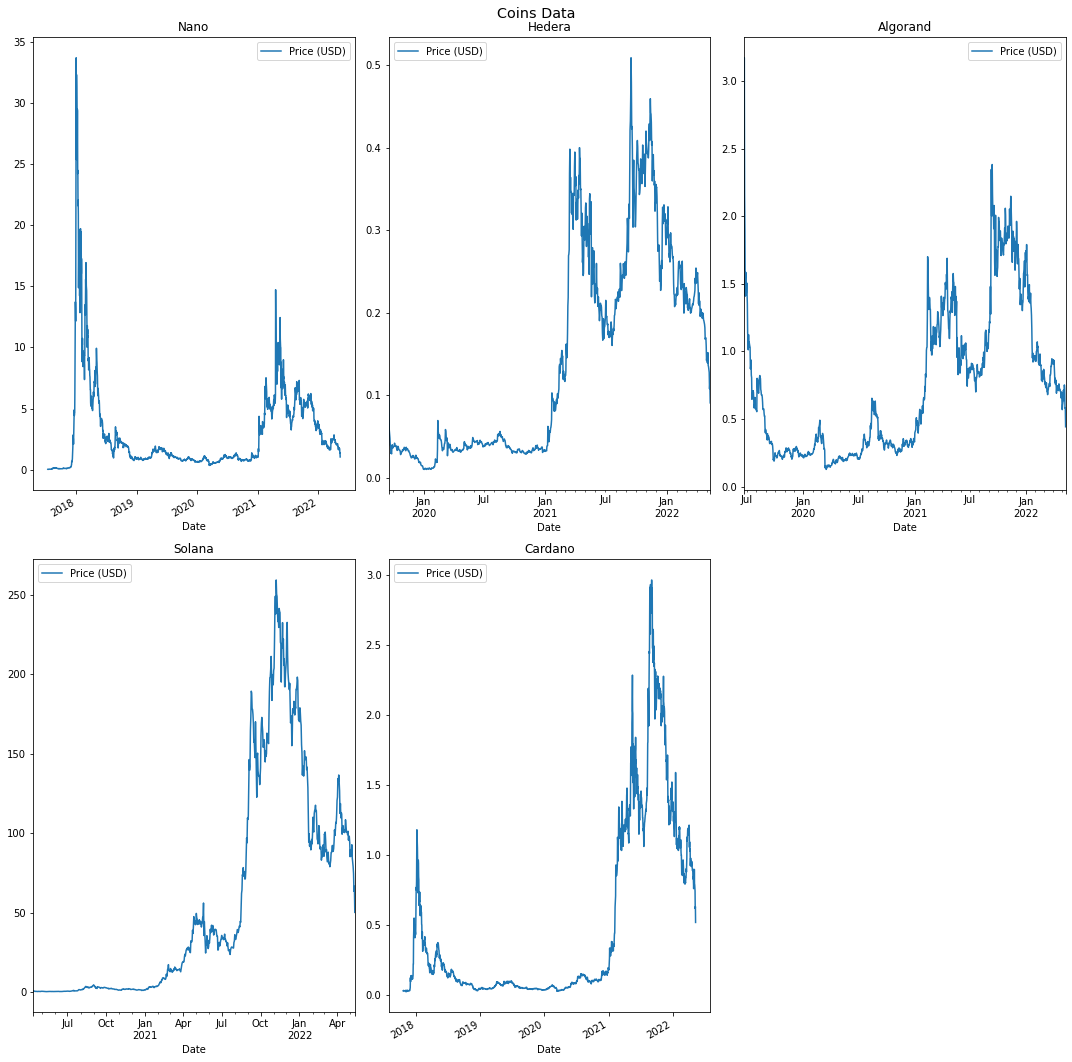

In [42]:
# Visualizations of raw general data
fig, axes = plt.subplots(2, 3, figsize=(15,15))
plt.suptitle("Coins Data", size='x-large')
for index, df in enumerate(coins_dfs):
    df.plot(ax=axes[index % 2, index % 3], x="Date", y="Price (USD)", kind="line", title=df.name)
axes[1, 2].set_visible(False)
fig.tight_layout()
plt.show()

### Prepare Coins Energy Data

In [43]:
# GOALS IN THIS CELL - 
#   Set kwh_per_tx for each coin (energy in kwh used per transaction)
#   Set tx_per_day for each coin (transactions performed per day)
#   Set kwh_per_day for each coin (energy in kwh used per day)

# Nano
nano.kwh_per_tx = 0.000112
nano.tx_per_day = 80000
nano.kwh_per_day = nano.kwh_per_tx * nano.tx_per_day

# Cardano
cardano.kwh_per_day = 7711.2
cardano.tx_per_day = 100000
cardano.kwh_per_tx = cardano.kwh_per_day / cardano.tx_per_day

# Algorand
algorand.kwh_per_tx = 0.0000008
algorand.tx_per_day = 500000
algorand.kwh_per_day = algorand.kwh_per_tx * algorand.tx_per_day

# Solana
solana.kwh_per_tx = 0.000752
solana.tx_per_year = 20000000000
solana.tx_per_day = solana.tx_per_year / 365
solana.kwh_per_day = solana.kwh_per_tx * solana.tx_per_day

# Hedera
hedera.kwh_per_tx = 0.00017
hedera.tx_per_day = 1093587
hedera.kwh_per_day = hedera.kwh_per_tx * hedera.tx_per_day